#Import Libraries

In [ ]:
!pip install tensorflow
import tensorflow as tf
print(tf.__version__)

2.18.0


In [ ]:
!pip install keras-tuner
import keras_tuner as kt
print("Keras Tuner is installed successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.4 MB/s eta 0:00:00
Keras Tuner is installed successfully!


In [ ]:
# Mengimpor kembali pustaka yang diperlukan setelah reset
import tensorflow as tf
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

#Import Data & Preprocessing Data

In [ ]:
# 1. Pra-pemrosesan Data (Tidak ada perubahan)
csv_url = 'https://docs.google.com/spreadsheets/d/1at1-KUFm4nnRxRl5TcPd9Yl3yD6hNiRL/gviz/tq?tqx=out:csv&sheet=data'
df = pd.read_csv(csv_url)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

train_size = int(len(df) * 0.8)
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]

feature_columns = ['tempmax', 'tempmin', 'dew', 'humidity', 'winddir']
f_transformer = MinMaxScaler()
f_transformer = f_transformer.fit(train[feature_columns])
train.loc[:, feature_columns] = f_transformer.transform(train[feature_columns])
test.loc[:, feature_columns] = f_transformer.transform(test[feature_columns])

temp_transformer = MinMaxScaler()
temp_transformer = temp_transformer.fit(train[['temp']])
train['temp'] = temp_transformer.transform(train[['temp']])
test['temp'] = temp_transformer.transform(test[['temp']])

X_train_values = train[feature_columns].values
y_train_values = train['temp'].values
X_test_values = test[feature_columns].values
y_test_values = test['temp'].values

y_test_actual_inv = temp_transformer.inverse_transform(y_test_values.reshape(-1, 1)).flatten()

/tmp/ipython-input-15-3618453782.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[:, feature_columns] = f_transformer.transform(train[feature_columns])
/tmp/ipython-input-15-3618453782.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, feature_columns] = f_transformer.transform(test[feature_columns])
/tmp/ipython-input-15-3618453782.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

# MLP Experiment

##No Dropout

In [ ]:
# 2. FUNGSI MODEL BARU tanpa Dropout (_d0)
def create_mlp_model_d0(activation_function, optimizer_name):
    """
    Membuat model Sequential Keras tanpa lapisan dropout.
    """
    # Nama model dinamis tanpa dropout
    model_name = f"mlp_{optimizer_name}_{activation_function}_d0"

    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_train_values.shape[1],)),
        tf.keras.layers.Dense(128, activation=activation_function),
        # PERUBAHAN: Lapisan Dropout dihapus
        tf.keras.layers.Dense(64, activation=activation_function),
        # PERUBAHAN: Lapisan Dropout dihapus
        tf.keras.layers.Dense(1)
    ], name=model_name)

    # Memilih optimizer berdasarkan nama
    if optimizer_name.lower() == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    elif optimizer_name.lower() == 'adagrad':
        optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001)
    elif optimizer_name.lower() == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae']
    )
    return model

In [ ]:
# 3. LOOP EKSPERIMEN dengan VARIABEL BARU (_d0)
results_list_d0 = []
all_predictions_d0 = {}

# Daftar hyperparameter yang akan diuji
optimizer_list = ['adam', 'adagrad', 'rmsprop']
activation_list = ['relu', 'tanh', 'sigmoid']

# Loop luar untuk optimizer
for optimizer_name in optimizer_list:
    # Loop dalam untuk fungsi aktivasi
    for activation_func in activation_list:
        # Memanggil fungsi model yang baru
        model = create_mlp_model_d0(activation_func, optimizer_name)
        print(f"--- Melatih Model: {model.name} ---")

        model.fit(
            X_train_values, y_train_values,
            validation_split=0.2,
            epochs=100,
            batch_size=32,
            verbose=0
        )
        print("Pelatihan selesai.")

        predictions_scaled = model.predict(X_test_values, verbose=0)
        predictions_inv = temp_transformer.inverse_transform(predictions_scaled).flatten()

        # Menyimpan ke dictionary yang baru
        all_predictions_d0[model.name] = predictions_inv

        # Evaluasi dan simpan hasil
        mse = mean_squared_error(y_test_actual_inv, predictions_inv)
        rmse = root_mean_squared_error(y_test_actual_inv, predictions_inv)
        mae = mean_absolute_error(y_test_actual_inv, predictions_inv)
        mape = mean_absolute_percentage_error(y_test_actual_inv, predictions_inv) * 100

        result_dict = {
            'Model': model.name,
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'MAPE (%)': mape
        }
        # Menambahkan ke list yang baru
        results_list_d0.append(result_dict)
        print(f"Hasil untuk model {model.name} telah disimpan.\n")

--- Melatih Model: mlp_adam_relu_d0 ---
Pelatihan selesai.
Hasil untuk model mlp_adam_relu_d0 telah disimpan.

--- Melatih Model: mlp_adam_tanh_d0 ---
Pelatihan selesai.
Hasil untuk model mlp_adam_tanh_d0 telah disimpan.

--- Melatih Model: mlp_adam_sigmoid_d0 ---
Pelatihan selesai.
Hasil untuk model mlp_adam_sigmoid_d0 telah disimpan.

--- Melatih Model: mlp_adagrad_relu_d0 ---
Pelatihan selesai.
Hasil untuk model mlp_adagrad_relu_d0 telah disimpan.

--- Melatih Model: mlp_adagrad_tanh_d0 ---
Pelatihan selesai.
Hasil untuk model mlp_adagrad_tanh_d0 telah disimpan.

--- Melatih Model: mlp_adagrad_sigmoid_d0 ---
Pelatihan selesai.
Hasil untuk model mlp_adagrad_sigmoid_d0 telah disimpan.

--- Melatih Model: mlp_rmsprop_relu_d0 ---
Pelatihan selesai.
Hasil untuk model mlp_rmsprop_relu_d0 telah disimpan.

--- Melatih Model: mlp_rmsprop_tanh_d0 ---
Pelatihan selesai.
Hasil untuk model mlp_rmsprop_tanh_d0 telah disimpan.

--- Melatih Model: mlp_rmsprop_sigmoid_d0 ---
Pelatihan selesai.
Hasil

In [ ]:
# 4. Menampilkan DataFrame Hasil Akhir untuk Eksperimen Tanpa Dropout
results_df_d0 = pd.DataFrame(results_list_d0)
results_df_d0.set_index('Model', inplace=True)
print(results_df_d0)

                             MSE      RMSE       MAE  MAPE (%)
Model                                                         
mlp_adam_relu_d0        0.024742  0.157297  0.098371  0.388001
mlp_adam_tanh_d0        0.064102  0.253185  0.139099  0.544070
mlp_adam_sigmoid_d0     0.055502  0.235589  0.206330  0.815047
mlp_adagrad_relu_d0     0.406873  0.637866  0.449256  1.748134
mlp_adagrad_tanh_d0     0.048892  0.221116  0.169361  0.677603
mlp_adagrad_sigmoid_d0  1.089132  1.043615  0.809428  3.230327
mlp_rmsprop_relu_d0     0.025336  0.159174  0.121397  0.474235
mlp_rmsprop_tanh_d0     0.095274  0.308665  0.168120  0.657213
mlp_rmsprop_sigmoid_d0  0.127207  0.356661  0.300562  1.200691


In [ ]:
results_df_d0.to_excel("mlp d0.xlsx", index='True')

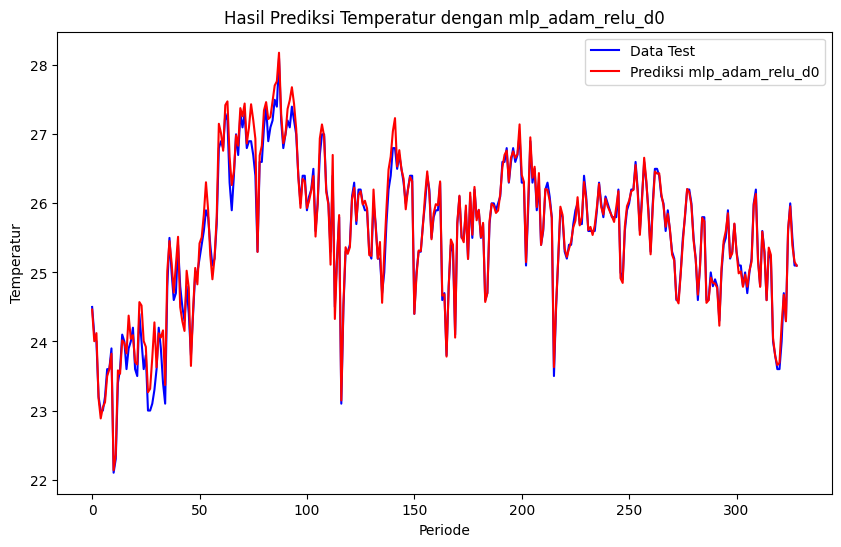

In [ ]:
# 5. Membuat Plot untuk salah satu model sebagai contoh dari eksperimen ini
model_name_to_plot_d0 = 'mlp_adam_relu_d0'

if model_name_to_plot_d0 in all_predictions_d0:
    predictions_to_plot_d0 = all_predictions_d0[model_name_to_plot_d0]
    plt.figure(figsize=(10, 6), facecolor='white')
    plt.plot(y_test_actual_inv, label='Data Test', color='blue')
    plt.plot(predictions_to_plot_d0, label=f'Prediksi {model_name_to_plot_d0}', color='red')
    plt.title(f'Hasil Prediksi Temperatur dengan {model_name_to_plot_d0}')
    plt.xlabel('Periode')
    plt.ylabel('Temperatur')
    plt.legend()
    plt.show()
else:
    print(f"Model {model_name_to_plot_d0} tidak ditemukan dalam hasil prediksi.")

##Dropout Rate 0.01

In [ ]:
# 2. PERUBAHAN: Fungsi untuk Membuat Model dengan 2 Argumen
def create_mlp_model(activation_function, optimizer_name):
    """
    Membuat model Sequential Keras dengan fungsi aktivasi dan optimizer yang ditentukan.
    """
    # Nama model dinamis berdasarkan kedua hyperparameter
    model_name = f"mlp_{optimizer_name}_{activation_function}_d1"

    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_train_values.shape[1],)),
        tf.keras.layers.Dense(128, activation=activation_function),
        tf.keras.layers.Dropout(0.01),
        tf.keras.layers.Dense(64, activation=activation_function),
        tf.keras.layers.Dropout(0.01),
        tf.keras.layers.Dense(1)
    ], name=model_name)

    # Memilih optimizer berdasarkan nama
    if optimizer_name.lower() == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    elif optimizer_name.lower() == 'adagrad':
        optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001)
    elif optimizer_name.lower() == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
    else:
        # Fallback ke Adam jika nama tidak dikenali
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae']
    )
    return model

In [ ]:
# 3. PERUBAHAN: Loop Eksperimen Bersarang (Nested Loop)
results_list = []
all_predictions = {}

# Tentukan daftar hyperparameter yang akan diuji
optimizer_list = ['adam', 'adagrad', 'rmsprop']
activation_list = ['relu', 'tanh', 'sigmoid']

# Loop luar untuk optimizer
for optimizer_name in optimizer_list:
    # Loop dalam untuk fungsi aktivasi
    for activation_func in activation_list:
        # Membuat model dengan kombinasi saat ini
        model = create_mlp_model(activation_func, optimizer_name)
        print(f"--- Melatih Model: {model.name} ---")

        model.fit(
            X_train_values, y_train_values,
            validation_split=0.2,
            epochs=100,
            batch_size=32,
            verbose=0
        )
        print("Pelatihan selesai.")

        predictions_scaled = model.predict(X_test_values, verbose=0)
        predictions_inv = temp_transformer.inverse_transform(predictions_scaled).flatten()
        all_predictions[model.name] = predictions_inv

        # Evaluasi dan simpan hasil
        mse = mean_squared_error(y_test_actual_inv, predictions_inv)
        rmse = root_mean_squared_error(y_test_actual_inv, predictions_inv)
        mae = mean_absolute_error(y_test_actual_inv, predictions_inv)
        mape = mean_absolute_percentage_error(y_test_actual_inv, predictions_inv) * 100

        result_dict = {
            'Model': model.name,
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'MAPE (%)': mape
        }
        results_list.append(result_dict)
        print(f"Hasil untuk model {model.name} telah disimpan.\n")

--- Melatih Model: mlp_adam_relu_d1 ---
Pelatihan selesai.
Hasil untuk model mlp_adam_relu_d1 telah disimpan.

--- Melatih Model: mlp_adam_tanh_d1 ---
Pelatihan selesai.
Hasil untuk model mlp_adam_tanh_d1 telah disimpan.

--- Melatih Model: mlp_adam_sigmoid_d1 ---
Pelatihan selesai.
Hasil untuk model mlp_adam_sigmoid_d1 telah disimpan.

--- Melatih Model: mlp_adagrad_relu_d1 ---
Pelatihan selesai.
Hasil untuk model mlp_adagrad_relu_d1 telah disimpan.

--- Melatih Model: mlp_adagrad_tanh_d1 ---
Pelatihan selesai.
Hasil untuk model mlp_adagrad_tanh_d1 telah disimpan.

--- Melatih Model: mlp_adagrad_sigmoid_d1 ---
Pelatihan selesai.
Hasil untuk model mlp_adagrad_sigmoid_d1 telah disimpan.

--- Melatih Model: mlp_rmsprop_relu_d1 ---
Pelatihan selesai.
Hasil untuk model mlp_rmsprop_relu_d1 telah disimpan.

--- Melatih Model: mlp_rmsprop_tanh_d1 ---
Pelatihan selesai.
Hasil untuk model mlp_rmsprop_tanh_d1 telah disimpan.

--- Melatih Model: mlp_rmsprop_sigmoid_d1 ---
Pelatihan selesai.
Hasil

In [ ]:
# 4. Menampilkan DataFrame Hasil Akhir
results_df = pd.DataFrame(results_list)
results_df.set_index('Model', inplace=True)
print(results_df)

                             MSE      RMSE       MAE  MAPE (%)
Model                                                         
mlp_adam_relu_d1        0.054169  0.232743  0.162693  0.637484
mlp_adam_tanh_d1        0.107608  0.328036  0.192574  0.755744
mlp_adam_sigmoid_d1     0.037690  0.194139  0.145855  0.582670
mlp_adagrad_relu_d1     0.287452  0.536146  0.380641  1.482501
mlp_adagrad_tanh_d1     0.083583  0.289107  0.228135  0.906261
mlp_adagrad_sigmoid_d1  1.059738  1.029436  0.799100  3.186980
mlp_rmsprop_relu_d1     0.023603  0.153633  0.100385  0.392080
mlp_rmsprop_tanh_d1     0.093986  0.306571  0.257632  1.003662
mlp_rmsprop_sigmoid_d1  0.057194  0.239153  0.172382  0.693531


In [ ]:
results_df.to_excel("mlp d1.xlsx", index='True')

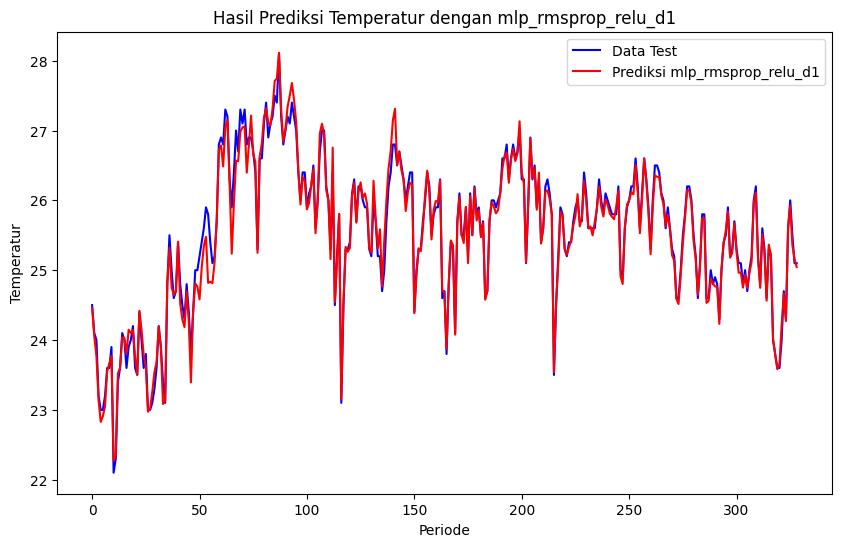

In [ ]:
# 5. Membuat Plot untuk salah satu model sebagai contoh
model_name_to_plot = 'mlp_rmsprop_relu_d1'

if model_name_to_plot in all_predictions:
    predictions_to_plot = all_predictions[model_name_to_plot]
    plt.figure(figsize=(10, 6), facecolor='white')
    plt.plot(y_test_actual_inv, label='Data Test', color='blue')
    plt.plot(predictions_to_plot, label=f'Prediksi {model_name_to_plot}', color='red')
    plt.title(f'Hasil Prediksi Temperatur dengan {model_name_to_plot}')
    plt.xlabel('Periode')
    plt.ylabel('Temperatur')
    plt.legend()
    plt.show()
else:
    print(f"Model {model_name_to_plot} tidak ditemukan dalam hasil prediksi.")

##Dropout Rate 0.05

In [ ]:
# 2. FUNGSI MODEL BARU dengan Dropout 0.05
def create_mlp_model_d05(activation_function, optimizer_name):
    """
    Membuat model Sequential Keras dengan dropout rate 0.05.
    """
    # Nama model dinamis untuk dropout 0.05
    model_name = f"mlp_{optimizer_name}_{activation_function}_d5"

    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_train_values.shape[1],)),
        tf.keras.layers.Dense(128, activation=activation_function),
        tf.keras.layers.Dropout(0.05),  # PERUBAHAN DI SINI
        tf.keras.layers.Dense(64, activation=activation_function),
        tf.keras.layers.Dropout(0.05),  # PERUBAHAN DI SINI
        tf.keras.layers.Dense(1)
    ], name=model_name)

    # Memilih optimizer berdasarkan nama
    if optimizer_name.lower() == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    elif optimizer_name.lower() == 'adagrad':
        optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001)
    elif optimizer_name.lower() == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae']
    )
    return model

In [ ]:
# 3. LOOP EKSPERIMEN dengan VARIABEL BARU
results_list_d05 = []
all_predictions_d05 = {}

# Daftar hyperparameter yang akan diuji (sama seperti sebelumnya)
optimizer_list = ['adam', 'adagrad', 'rmsprop']
activation_list = ['relu', 'tanh', 'sigmoid']

# Loop luar untuk optimizer
for optimizer_name in optimizer_list:
    # Loop dalam untuk fungsi aktivasi
    for activation_func in activation_list:
        # Memanggil fungsi model yang baru
        model = create_mlp_model_d05(activation_func, optimizer_name)
        print(f"--- Melatih Model: {model.name} ---")

        model.fit(
            X_train_values, y_train_values,
            validation_split=0.2,
            epochs=100,
            batch_size=32,
            verbose=0
        )
        print("Pelatihan selesai.")

        predictions_scaled = model.predict(X_test_values, verbose=0)
        predictions_inv = temp_transformer.inverse_transform(predictions_scaled).flatten()

        # Menyimpan ke dictionary yang baru
        all_predictions_d05[model.name] = predictions_inv

        # Evaluasi dan simpan hasil
        mse = mean_squared_error(y_test_actual_inv, predictions_inv)
        rmse = root_mean_squared_error(y_test_actual_inv, predictions_inv)
        mae = mean_absolute_error(y_test_actual_inv, predictions_inv)
        mape = mean_absolute_percentage_error(y_test_actual_inv, predictions_inv) * 100

        result_dict = {
            'Model': model.name,
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'MAPE (%)': mape
        }
        # Menambahkan ke list yang baru
        results_list_d05.append(result_dict)
        print(f"Hasil untuk model {model.name} telah disimpan.\n")

--- Melatih Model: mlp_adam_relu_d5 ---
Pelatihan selesai.
Hasil untuk model mlp_adam_relu_d5 telah disimpan.

--- Melatih Model: mlp_adam_tanh_d5 ---
Pelatihan selesai.
Hasil untuk model mlp_adam_tanh_d5 telah disimpan.

--- Melatih Model: mlp_adam_sigmoid_d5 ---
Pelatihan selesai.
Hasil untuk model mlp_adam_sigmoid_d5 telah disimpan.

--- Melatih Model: mlp_adagrad_relu_d5 ---
Pelatihan selesai.
Hasil untuk model mlp_adagrad_relu_d5 telah disimpan.

--- Melatih Model: mlp_adagrad_tanh_d5 ---
Pelatihan selesai.
Hasil untuk model mlp_adagrad_tanh_d5 telah disimpan.

--- Melatih Model: mlp_adagrad_sigmoid_d5 ---
Pelatihan selesai.
Hasil untuk model mlp_adagrad_sigmoid_d5 telah disimpan.

--- Melatih Model: mlp_rmsprop_relu_d5 ---
Pelatihan selesai.
Hasil untuk model mlp_rmsprop_relu_d5 telah disimpan.

--- Melatih Model: mlp_rmsprop_tanh_d5 ---
Pelatihan selesai.
Hasil untuk model mlp_rmsprop_tanh_d5 telah disimpan.

--- Melatih Model: mlp_rmsprop_sigmoid_d5 ---
Pelatihan selesai.
Hasil

In [ ]:
# 4. Menampilkan DataFrame Hasil Akhir untuk Eksperimen Dropout 0.05
results_df_d05 = pd.DataFrame(results_list_d05)
results_df_d05.set_index('Model', inplace=True)
print(results_df_d05)

                             MSE      RMSE       MAE  MAPE (%)
Model                                                         
mlp_adam_relu_d5        0.034570  0.185930  0.124057  0.490295
mlp_adam_tanh_d5        0.138916  0.372714  0.204391  0.799171
mlp_adam_sigmoid_d5     0.053490  0.231279  0.171120  0.687895
mlp_adagrad_relu_d5     0.270241  0.519847  0.385636  1.532612
mlp_adagrad_tanh_d5     0.039024  0.197545  0.149311  0.597250
mlp_adagrad_sigmoid_d5  1.091255  1.044631  0.806294  3.221250
mlp_rmsprop_relu_d5     0.029993  0.173185  0.133311  0.523093
mlp_rmsprop_tanh_d5     0.108904  0.330006  0.205435  0.798159
mlp_rmsprop_sigmoid_d5  0.064116  0.253211  0.188846  0.758748


In [ ]:
results_df_d05.to_excel("mlp d5.xlsx", index='True')

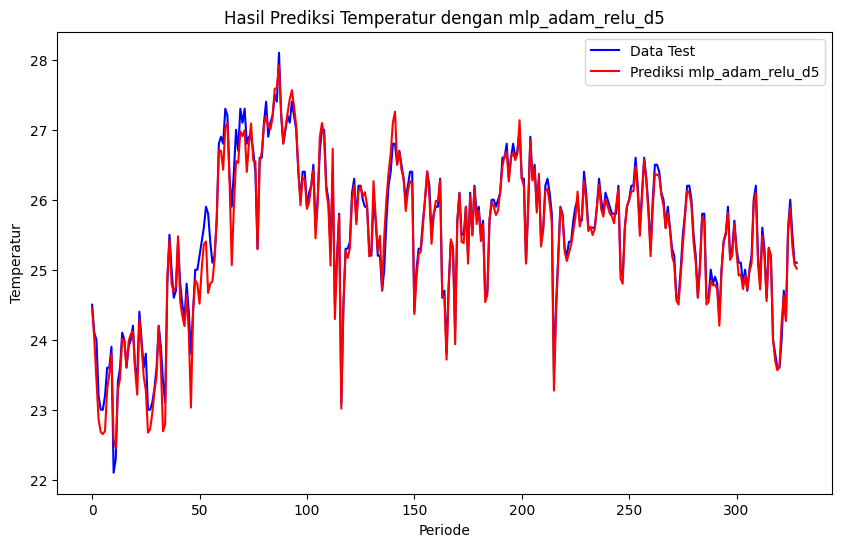

In [ ]:
# 5. Membuat Plot untuk salah satu model sebagai contoh dari eksperimen ini
model_name_to_plot_d05 = 'mlp_adam_relu_d5'

if model_name_to_plot_d05 in all_predictions_d05:
    predictions_to_plot_d05 = all_predictions_d05[model_name_to_plot_d05]
    plt.figure(figsize=(10, 6), facecolor='white')
    plt.plot(y_test_actual_inv, label='Data Test', color='blue')
    plt.plot(predictions_to_plot_d05, label=f'Prediksi {model_name_to_plot_d05}', color='red')
    plt.title(f'Hasil Prediksi Temperatur dengan {model_name_to_plot_d05}')
    plt.xlabel('Periode')
    plt.ylabel('Temperatur')
    plt.legend()
    plt.show()
else:
    print(f"Model {model_name_to_plot_d05} tidak ditemukan dalam hasil prediksi.")

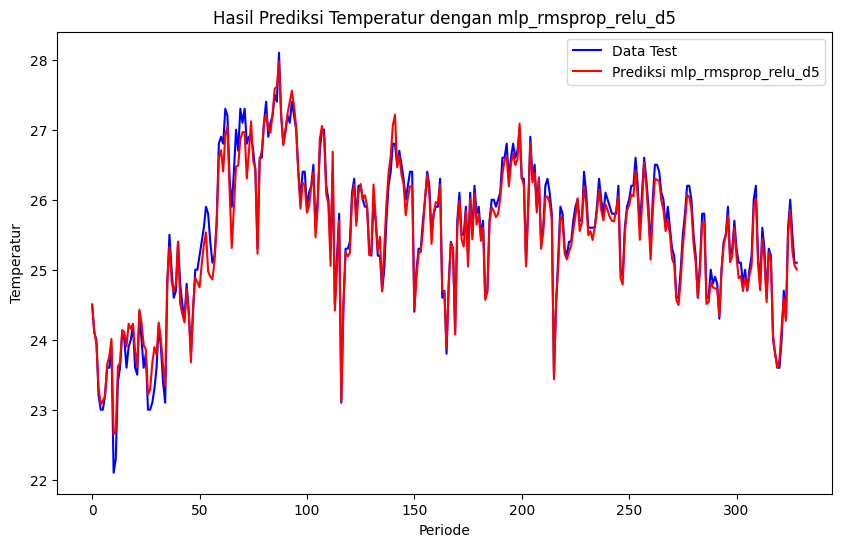

In [ ]:
# 5. Membuat Plot untuk salah satu model sebagai contoh dari eksperimen ini
model_name_to_plot_d05 = 'mlp_rmsprop_relu_d5'

if model_name_to_plot_d05 in all_predictions_d05:
    predictions_to_plot_d05 = all_predictions_d05[model_name_to_plot_d05]
    plt.figure(figsize=(10, 6), facecolor='white')
    plt.plot(y_test_actual_inv, label='Data Test', color='blue')
    plt.plot(predictions_to_plot_d05, label=f'Prediksi {model_name_to_plot_d05}', color='red')
    plt.title(f'Hasil Prediksi Temperatur dengan {model_name_to_plot_d05}')
    plt.xlabel('Periode')
    plt.ylabel('Temperatur')
    plt.legend()
    plt.show()
else:
    print(f"Model {model_name_to_plot_d05} tidak ditemukan dalam hasil prediksi.")

##Dropout Rate 0.1

In [ ]:
# 2. FUNGSI MODEL BARU dengan penamaan _d10
def create_mlp_model_d10(activation_function, optimizer_name):
    """
    Membuat model Sequential Keras dengan dropout rate 0.1.
    """
    # Nama model dinamis untuk dropout 0.1 dengan akhiran _d10
    model_name = f"mlp_{optimizer_name}_{activation_function}_d10"

    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_train_values.shape[1],)),
        tf.keras.layers.Dense(128, activation=activation_function),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(64, activation=activation_function),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(1)
    ], name=model_name)

    # Memilih optimizer berdasarkan nama
    if optimizer_name.lower() == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    elif optimizer_name.lower() == 'adagrad':
        optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001)
    elif optimizer_name.lower() == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae']
    )
    return model

In [ ]:
# 3. LOOP EKSPERIMEN dengan VARIABEL BARU (_d10)
results_list_d10 = []
all_predictions_d10 = {}

# Daftar hyperparameter yang akan diuji
optimizer_list = ['adam', 'adagrad', 'rmsprop']
activation_list = ['relu', 'tanh', 'sigmoid']

# Loop luar untuk optimizer
for optimizer_name in optimizer_list:
    # Loop dalam untuk fungsi aktivasi
    for activation_func in activation_list:
        # Memanggil fungsi model yang baru
        model = create_mlp_model_d10(activation_func, optimizer_name)
        print(f"--- Melatih Model: {model.name} ---")

        model.fit(
            X_train_values, y_train_values,
            validation_split=0.2,
            epochs=100,
            batch_size=32,
            verbose=0
        )
        print("Pelatihan selesai.")

        predictions_scaled = model.predict(X_test_values, verbose=0)
        predictions_inv = temp_transformer.inverse_transform(predictions_scaled).flatten()

        # Menyimpan ke dictionary yang baru
        all_predictions_d10[model.name] = predictions_inv

        # Evaluasi dan simpan hasil
        mse = mean_squared_error(y_test_actual_inv, predictions_inv)
        rmse = root_mean_squared_error(y_test_actual_inv, predictions_inv)
        mae = mean_absolute_error(y_test_actual_inv, predictions_inv)
        mape = mean_absolute_percentage_error(y_test_actual_inv, predictions_inv) * 100

        result_dict = {
            'Model': model.name,
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'MAPE (%)': mape
        }
        # Menambahkan ke list yang baru
        results_list_d10.append(result_dict)
        print(f"Hasil untuk model {model.name} telah disimpan.\n")

--- Melatih Model: mlp_adam_relu_d10 ---
Pelatihan selesai.
Hasil untuk model mlp_adam_relu_d10 telah disimpan.

--- Melatih Model: mlp_adam_tanh_d10 ---
Pelatihan selesai.
Hasil untuk model mlp_adam_tanh_d10 telah disimpan.

--- Melatih Model: mlp_adam_sigmoid_d10 ---
Pelatihan selesai.
Hasil untuk model mlp_adam_sigmoid_d10 telah disimpan.

--- Melatih Model: mlp_adagrad_relu_d10 ---
Pelatihan selesai.
Hasil untuk model mlp_adagrad_relu_d10 telah disimpan.

--- Melatih Model: mlp_adagrad_tanh_d10 ---
Pelatihan selesai.
Hasil untuk model mlp_adagrad_tanh_d10 telah disimpan.

--- Melatih Model: mlp_adagrad_sigmoid_d10 ---
Pelatihan selesai.
Hasil untuk model mlp_adagrad_sigmoid_d10 telah disimpan.

--- Melatih Model: mlp_rmsprop_relu_d10 ---
Pelatihan selesai.
Hasil untuk model mlp_rmsprop_relu_d10 telah disimpan.

--- Melatih Model: mlp_rmsprop_tanh_d10 ---
Pelatihan selesai.
Hasil untuk model mlp_rmsprop_tanh_d10 telah disimpan.

--- Melatih Model: mlp_rmsprop_sigmoid_d10 ---
Pelatih

In [ ]:
# 4. Menampilkan DataFrame Hasil Akhir untuk Eksperimen Dropout 0.1
results_df_d10 = pd.DataFrame(results_list_d10)
results_df_d10.set_index('Model', inplace=True)
print(results_df_d10)

                              MSE      RMSE       MAE  MAPE (%)
Model                                                          
mlp_adam_relu_d10        0.025110  0.158463  0.100729  0.395022
mlp_adam_tanh_d10        0.080657  0.284001  0.155894  0.606794
mlp_adam_sigmoid_d10     0.088127  0.296862  0.212529  0.859634
mlp_adagrad_relu_d10     0.383433  0.619220  0.474201  1.860439
mlp_adagrad_tanh_d10     0.103934  0.322388  0.232228  0.937879
mlp_adagrad_sigmoid_d10  1.072942  1.035829  0.804974  3.210152
mlp_rmsprop_relu_d10     0.030236  0.173886  0.148978  0.583937
mlp_rmsprop_tanh_d10     0.085647  0.292656  0.157227  0.611685
mlp_rmsprop_sigmoid_d10  0.089668  0.299446  0.240561  0.949015


In [ ]:
results_df_d10.to_excel("mlp d10.xlsx", index='True')

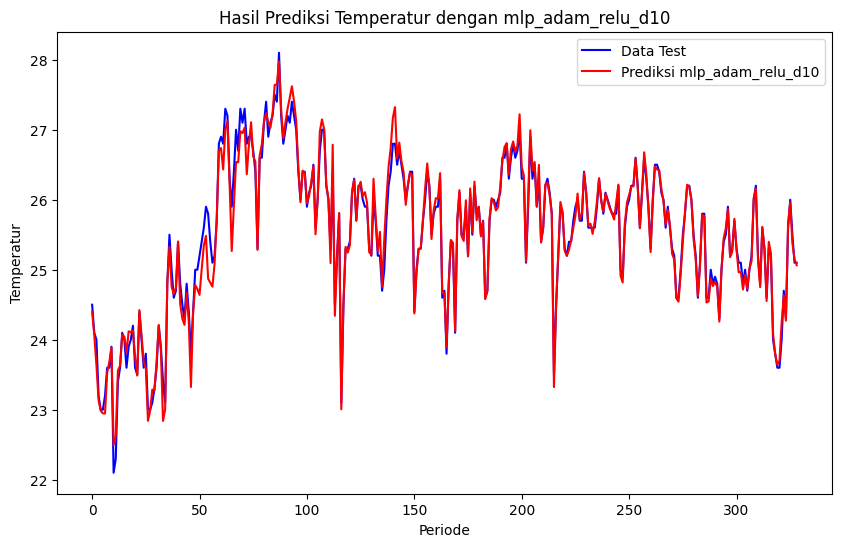

In [ ]:
# 5. Membuat Plot untuk salah satu model sebagai contoh dari eksperimen ini
model_name_to_plot_d10 = 'mlp_adam_relu_d10'

if model_name_to_plot_d10 in all_predictions_d10:
    predictions_to_plot_d10 = all_predictions_d10[model_name_to_plot_d10]
    plt.figure(figsize=(10, 6), facecolor='white')
    plt.plot(y_test_actual_inv, label='Data Test', color='blue')
    plt.plot(predictions_to_plot_d10, label=f'Prediksi {model_name_to_plot_d10}', color='red')
    plt.title(f'Hasil Prediksi Temperatur dengan {model_name_to_plot_d10}')
    plt.xlabel('Periode')
    plt.ylabel('Temperatur')
    plt.legend()
    plt.show()
else:
    print(f"Model {model_name_to_plot_d10} tidak ditemukan dalam hasil prediksi.")

##Dropout Rate 0.15

In [ ]:
# 2. FUNGSI MODEL BARU dengan Dropout 0.15
def create_mlp_model_d15(activation_function, optimizer_name):
    """
    Membuat model Sequential Keras dengan dropout rate 0.15.
    """
    # Nama model dinamis untuk dropout 0.15
    model_name = f"mlp_{optimizer_name}_{activation_function}_d15"

    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_train_values.shape[1],)),
        tf.keras.layers.Dense(128, activation=activation_function),
        tf.keras.layers.Dropout(0.15),  # PERUBAHAN DI SINI
        tf.keras.layers.Dense(64, activation=activation_function),
        tf.keras.layers.Dropout(0.15),  # PERUBAHAN DI SINI
        tf.keras.layers.Dense(1)
    ], name=model_name)

    # Memilih optimizer berdasarkan nama
    if optimizer_name.lower() == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    elif optimizer_name.lower() == 'adagrad':
        optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001)
    elif optimizer_name.lower() == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae']
    )
    return model

In [ ]:
# 3. LOOP EKSPERIMEN dengan VARIABEL BARU (_d15)
results_list_d15 = []
all_predictions_d15 = {}

# Daftar hyperparameter yang akan diuji
optimizer_list = ['adam', 'adagrad', 'rmsprop']
activation_list = ['relu', 'tanh', 'sigmoid']

# Loop luar untuk optimizer
for optimizer_name in optimizer_list:
    # Loop dalam untuk fungsi aktivasi
    for activation_func in activation_list:
        # Memanggil fungsi model yang baru
        model = create_mlp_model_d15(activation_func, optimizer_name)
        print(f"--- Melatih Model: {model.name} ---")

        model.fit(
            X_train_values, y_train_values,
            validation_split=0.2,
            epochs=100,
            batch_size=32,
            verbose=0
        )
        print("Pelatihan selesai.")

        predictions_scaled = model.predict(X_test_values, verbose=0)
        predictions_inv = temp_transformer.inverse_transform(predictions_scaled).flatten()

        # Menyimpan ke dictionary yang baru
        all_predictions_d15[model.name] = predictions_inv

        # Evaluasi dan simpan hasil
        mse = mean_squared_error(y_test_actual_inv, predictions_inv)
        rmse = root_mean_squared_error(y_test_actual_inv, predictions_inv)
        mae = mean_absolute_error(y_test_actual_inv, predictions_inv)
        mape = mean_absolute_percentage_error(y_test_actual_inv, predictions_inv) * 100

        result_dict = {
            'Model': model.name,
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'MAPE (%)': mape
        }
        # Menambahkan ke list yang baru
        results_list_d15.append(result_dict)
        print(f"Hasil untuk model {model.name} telah disimpan.\n")

--- Melatih Model: mlp_adam_relu_d15 ---
Pelatihan selesai.
Hasil untuk model mlp_adam_relu_d15 telah disimpan.

--- Melatih Model: mlp_adam_tanh_d15 ---
Pelatihan selesai.
Hasil untuk model mlp_adam_tanh_d15 telah disimpan.

--- Melatih Model: mlp_adam_sigmoid_d15 ---
Pelatihan selesai.
Hasil untuk model mlp_adam_sigmoid_d15 telah disimpan.

--- Melatih Model: mlp_adagrad_relu_d15 ---
Pelatihan selesai.
Hasil untuk model mlp_adagrad_relu_d15 telah disimpan.

--- Melatih Model: mlp_adagrad_tanh_d15 ---
Pelatihan selesai.
Hasil untuk model mlp_adagrad_tanh_d15 telah disimpan.

--- Melatih Model: mlp_adagrad_sigmoid_d15 ---
Pelatihan selesai.
Hasil untuk model mlp_adagrad_sigmoid_d15 telah disimpan.

--- Melatih Model: mlp_rmsprop_relu_d15 ---
Pelatihan selesai.
Hasil untuk model mlp_rmsprop_relu_d15 telah disimpan.

--- Melatih Model: mlp_rmsprop_tanh_d15 ---
Pelatihan selesai.
Hasil untuk model mlp_rmsprop_tanh_d15 telah disimpan.

--- Melatih Model: mlp_rmsprop_sigmoid_d15 ---
Pelatih

In [ ]:
# 4. Menampilkan DataFrame Hasil Akhir untuk Eksperimen Dropout 0.15
results_df_d15 = pd.DataFrame(results_list_d15)
results_df_d15.set_index('Model', inplace=True)
print(results_df_d15)

                              MSE      RMSE       MAE  MAPE (%)
Model                                                          
mlp_adam_relu_d15        0.024011  0.154954  0.108363  0.427440
mlp_adam_tanh_d15        0.112615  0.335582  0.181973  0.708101
mlp_adam_sigmoid_d15     0.094204  0.306927  0.237061  0.943509
mlp_adagrad_relu_d15     0.429787  0.655581  0.491572  1.914789
mlp_adagrad_tanh_d15     0.088284  0.297126  0.220264  0.885794
mlp_adagrad_sigmoid_d15  1.114738  1.055812  0.818305  3.265417
mlp_rmsprop_relu_d15     0.046985  0.216759  0.178861  0.706342
mlp_rmsprop_tanh_d15     0.091448  0.302403  0.262011  1.022244
mlp_rmsprop_sigmoid_d15  0.166091  0.407543  0.341476  1.336904


In [ ]:
results_df_d15.to_excel("mlp d15.xlsx", index='True')

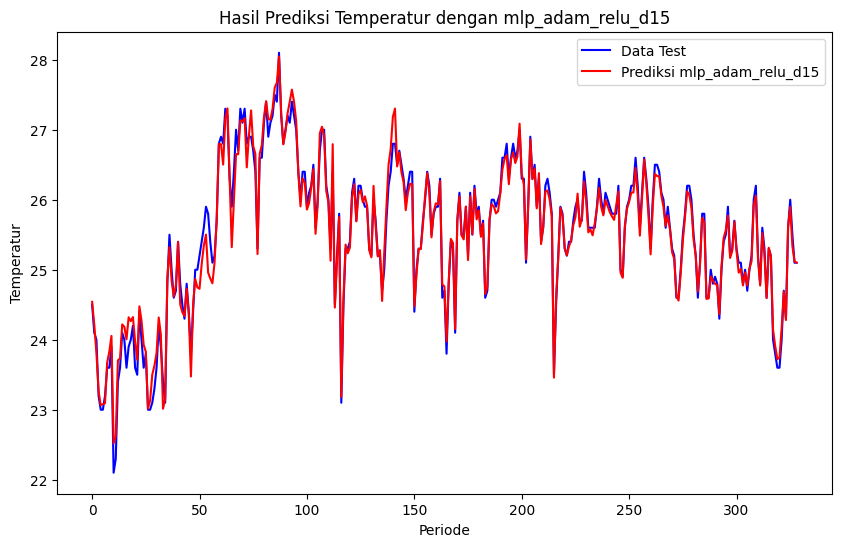

In [ ]:
# 5. Membuat Plot untuk salah satu model sebagai contoh dari eksperimen ini
model_name_to_plot_d15 = 'mlp_adam_relu_d15'

if model_name_to_plot_d15 in all_predictions_d15:
    predictions_to_plot_d15 = all_predictions_d15[model_name_to_plot_d15]
    plt.figure(figsize=(10, 6), facecolor='white')
    plt.plot(y_test_actual_inv, label='Data Test', color='blue')
    plt.plot(predictions_to_plot_d15, label=f'Prediksi {model_name_to_plot_d15}', color='red')
    plt.title(f'Hasil Prediksi Temperatur dengan {model_name_to_plot_d15}')
    plt.xlabel('Periode')
    plt.ylabel('Temperatur')
    plt.legend()
    plt.show()
else:
    print(f"Model {model_name_to_plot_d15} tidak ditemukan dalam hasil prediksi.")

##Dropout Rate 0.2

In [ ]:
# 2. FUNGSI MODEL BARU dengan Dropout 0.2
def create_mlp_model_d20(activation_function, optimizer_name):
    """
    Membuat model Sequential Keras dengan dropout rate 0.2.
    """
    # Nama model dinamis untuk dropout 0.2
    model_name = f"mlp_{optimizer_name}_{activation_function}_d20"

    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_train_values.shape[1],)),
        tf.keras.layers.Dense(128, activation=activation_function),
        tf.keras.layers.Dropout(0.2),  # PERUBAHAN DI SINI
        tf.keras.layers.Dense(64, activation=activation_function),
        tf.keras.layers.Dropout(0.2),  # PERUBAHAN DI SINI
        tf.keras.layers.Dense(1)
    ], name=model_name)

    # Memilih optimizer berdasarkan nama
    if optimizer_name.lower() == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    elif optimizer_name.lower() == 'adagrad':
        optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001)
    elif optimizer_name.lower() == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae']
    )
    return model

In [ ]:
# 3. LOOP EKSPERIMEN dengan VARIABEL BARU (_d20)
results_list_d20 = []
all_predictions_d20 = {}

# Daftar hyperparameter yang akan diuji
optimizer_list = ['adam', 'adagrad', 'rmsprop']
activation_list = ['relu', 'tanh', 'sigmoid']

# Loop luar untuk optimizer
for optimizer_name in optimizer_list:
    # Loop dalam untuk fungsi aktivasi
    for activation_func in activation_list:
        # Memanggil fungsi model yang baru
        model = create_mlp_model_d20(activation_func, optimizer_name)
        print(f"--- Melatih Model: {model.name} ---")

        model.fit(
            X_train_values, y_train_values,
            validation_split=0.2,
            epochs=100,
            batch_size=32,
            verbose=0
        )
        print("Pelatihan selesai.")

        predictions_scaled = model.predict(X_test_values, verbose=0)
        predictions_inv = temp_transformer.inverse_transform(predictions_scaled).flatten()

        # Menyimpan ke dictionary yang baru
        all_predictions_d20[model.name] = predictions_inv

        # Evaluasi dan simpan hasil
        mse = mean_squared_error(y_test_actual_inv, predictions_inv)
        rmse = root_mean_squared_error(y_test_actual_inv, predictions_inv)
        mae = mean_absolute_error(y_test_actual_inv, predictions_inv)
        mape = mean_absolute_percentage_error(y_test_actual_inv, predictions_inv) * 100

        result_dict = {
            'Model': model.name,
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'MAPE (%)': mape
        }
        # Menambahkan ke list yang baru
        results_list_d20.append(result_dict)
        print(f"Hasil untuk model {model.name} telah disimpan.\n")

--- Melatih Model: mlp_adam_relu_d20 ---
Pelatihan selesai.
Hasil untuk model mlp_adam_relu_d20 telah disimpan.

--- Melatih Model: mlp_adam_tanh_d20 ---
Pelatihan selesai.
Hasil untuk model mlp_adam_tanh_d20 telah disimpan.

--- Melatih Model: mlp_adam_sigmoid_d20 ---
Pelatihan selesai.
Hasil untuk model mlp_adam_sigmoid_d20 telah disimpan.

--- Melatih Model: mlp_adagrad_relu_d20 ---
Pelatihan selesai.
Hasil untuk model mlp_adagrad_relu_d20 telah disimpan.

--- Melatih Model: mlp_adagrad_tanh_d20 ---
Pelatihan selesai.
Hasil untuk model mlp_adagrad_tanh_d20 telah disimpan.

--- Melatih Model: mlp_adagrad_sigmoid_d20 ---
Pelatihan selesai.
Hasil untuk model mlp_adagrad_sigmoid_d20 telah disimpan.

--- Melatih Model: mlp_rmsprop_relu_d20 ---
Pelatihan selesai.
Hasil untuk model mlp_rmsprop_relu_d20 telah disimpan.

--- Melatih Model: mlp_rmsprop_tanh_d20 ---
Pelatihan selesai.
Hasil untuk model mlp_rmsprop_tanh_d20 telah disimpan.

--- Melatih Model: mlp_rmsprop_sigmoid_d20 ---
Pelatih

In [ ]:
# 4. Menampilkan DataFrame Hasil Akhir untuk Eksperimen Dropout 0.2
results_df_d20 = pd.DataFrame(results_list_d20)
results_df_d20.set_index('Model', inplace=True)
print(results_df_d20)

                              MSE      RMSE       MAE  MAPE (%)
Model                                                          
mlp_adam_relu_d20        0.031947  0.178736  0.117010  0.463482
mlp_adam_tanh_d20        0.119413  0.345561  0.191653  0.750378
mlp_adam_sigmoid_d20     0.098050  0.313130  0.226993  0.910927
mlp_adagrad_relu_d20     0.386303  0.621532  0.470311  1.842694
mlp_adagrad_tanh_d20     0.111241  0.333528  0.264655  1.047863
mlp_adagrad_sigmoid_d20  1.076763  1.037672  0.810952  3.228415
mlp_rmsprop_relu_d20     0.031890  0.178577  0.139994  0.545002
mlp_rmsprop_tanh_d20     0.090122  0.300204  0.174059  0.678907
mlp_rmsprop_sigmoid_d20  0.144279  0.379840  0.287092  1.144311


In [ ]:
results_df_d20.to_excel("mlp d20.xlsx", index='True')

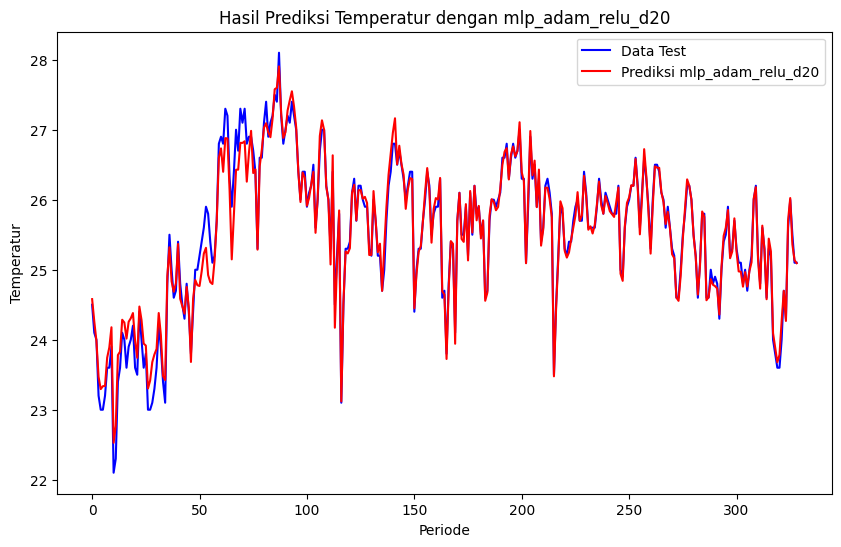

In [ ]:
# 5. Membuat Plot untuk salah satu model sebagai contoh dari eksperimen ini
model_name_to_plot_d20 = 'mlp_adam_relu_d20'

if model_name_to_plot_d20 in all_predictions_d20:
    predictions_to_plot_d20 = all_predictions_d20[model_name_to_plot_d20]
    plt.figure(figsize=(10, 6), facecolor='white')
    plt.plot(y_test_actual_inv, label='Data Test', color='blue')
    plt.plot(predictions_to_plot_d20, label=f'Prediksi {model_name_to_plot_d20}', color='red')
    plt.title(f'Hasil Prediksi Temperatur dengan {model_name_to_plot_d20}')
    plt.xlabel('Periode')
    plt.ylabel('Temperatur')
    plt.legend()
    plt.show()
else:
    print(f"Model {model_name_to_plot_d20} tidak ditemukan dalam hasil prediksi.")

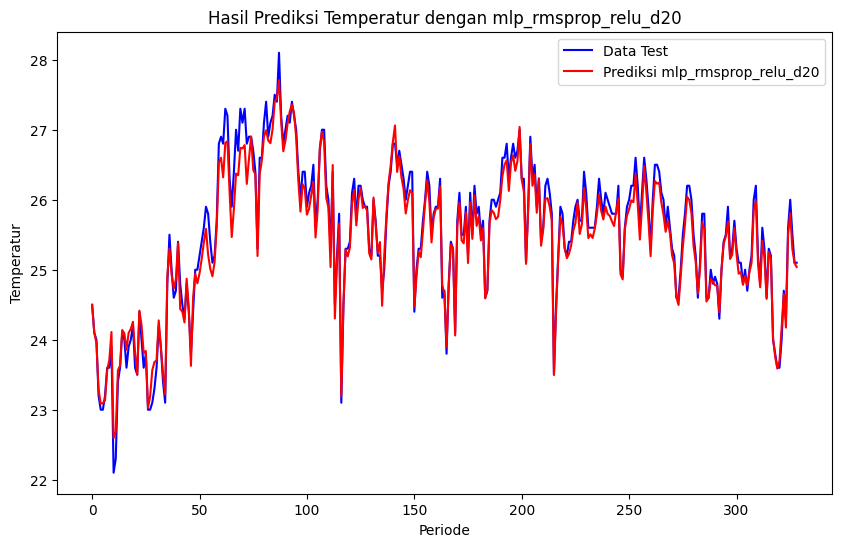

In [ ]:
# 5. Membuat Plot untuk salah satu model sebagai contoh dari eksperimen ini
model_name_to_plot_d20 = 'mlp_rmsprop_relu_d20'

if model_name_to_plot_d20 in all_predictions_d20:
    predictions_to_plot_d20 = all_predictions_d20[model_name_to_plot_d20]
    plt.figure(figsize=(10, 6), facecolor='white')
    plt.plot(y_test_actual_inv, label='Data Test', color='blue')
    plt.plot(predictions_to_plot_d20, label=f'Prediksi {model_name_to_plot_d20}', color='red')
    plt.title(f'Hasil Prediksi Temperatur dengan {model_name_to_plot_d20}')
    plt.xlabel('Periode')
    plt.ylabel('Temperatur')
    plt.legend()
    plt.show()
else:
    print(f"Model {model_name_to_plot_d20} tidak ditemukan dalam hasil prediksi.")

## R^2 Score

In [ ]:
import pandas as pd
from sklearn.metrics import r2_score

# 1. Gabungkan semua dictionary prediksi menjadi satu
master_all_predictions = {}
# Menambahkan try-except untuk keamanan jika ada variabel yang belum terdefinisi
try:
    master_all_predictions.update(all_predictions)       # Dari eksperimen d01
    master_all_predictions.update(all_predictions_d0)    # Dari eksperimen d0
    master_all_predictions.update(all_predictions_d05)   # Dari eksperimen d05
    master_all_predictions.update(all_predictions_d10)   # Dari eksperimen d10
    master_all_predictions.update(all_predictions_d15)   # Dari eksperimen d15
    master_all_predictions.update(all_predictions_d20)   # Dari eksperimen d20
    print("Berhasil menggabungkan semua hasil prediksi.")
except NameError as e:
    print(f"Error: Pastikan semua variabel prediksi sudah ada. Variabel yang hilang: {e}")

# 2. Siapkan daftar model yang ingin dievaluasi
# Catatan: Nama model disesuaikan dengan yang dihasilkan oleh skrip.
# 'd1' menjadi 'd01', 'd5' menjadi 'd05', dst.
models_to_evaluate = [
    'mlp_adam_relu_d0',
    'mlp_rmsprop_relu_d1',
    'mlp_adam_relu_d5',
    'mlp_rmsprop_relu_d5',
    'mlp_adam_relu_d10',
    'mlp_adam_relu_d15',
    'mlp_adam_relu_d20',
    'mlp_rmsprop_relu_d20'
]

Berhasil menggabungkan semua hasil prediksi.


In [ ]:

# 3. Iterasi, hitung R-Squared, dan simpan hasilnya
r2_results_list = []

for model_name in models_to_evaluate:
    if model_name in master_all_predictions:
        # Ambil prediksi untuk model saat ini
        predictions = master_all_predictions[model_name]

        # Hitung R-Squared
        # Variabel y_test_actual_inv harus sudah ada dari pra-pemrosesan
        r2_value = r2_score(y_test_actual_inv, predictions)

        # Simpan hasilnya dalam dictionary
        r2_results_list.append({
            'Model': model_name,
            'R-Squared (R²)': r2_value
        })
    else:
        print(f"Peringatan: Model '{model_name}' tidak ditemukan dalam hasil prediksi.")

In [ ]:
# 4. Buat dan tampilkan DataFrame
r2_results_df = pd.DataFrame(r2_results_list)
print(r2_results_df)
r2_results_df.to_excel("mlp r2.xlsx", index='True')

                  Model  R-Squared (R²)
0      mlp_adam_relu_d0        0.977434
1   mlp_rmsprop_relu_d1        0.978473
2      mlp_adam_relu_d5        0.968471
3   mlp_rmsprop_relu_d5        0.972646
4     mlp_adam_relu_d10        0.977099
5     mlp_adam_relu_d15        0.978102
6     mlp_adam_relu_d20        0.970864
7  mlp_rmsprop_relu_d20        0.970916
